In [3]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
tf_device = '/gpu:0'

In [4]:

from skimage.io import imread_collection
from skimage.transform import resize
from skimage.color import rgb2gray

from skimage.filters import threshold_otsu


In [5]:
def funcaoPlot(imagens, title=None):
    fig, ax = plt.subplots(1, len(imagens), figsize=(60, 60))
    for i, folha in enumerate(imagens):
        ax[i].imshow(folha, cmap="gray")
        if title:
            ax[i].set_title(title[i])
        else:
            ax[i].set_title(str(i))

In [6]:

from tqdm import tqdm
from sklearn.cluster import estimate_bandwidth, MeanShift


def aplicar_menshift(list_img):
    images = list_img
    list_img_bin = []
    for img in tqdm(images, desc="Processando Mean Shift"):
        list_img_bin.append(aplicaMeanShiftOneImg(img))
    return list_img_bin


def aplicar_preprocessamento(list_img):
    images = list_img
    list_img_foreground = []
    for img in images:
        img_gray = rgb2gray(img.copy())
        img_otsu = aplicaOtsuOneImg(img_gray)
        foreground = (img_gray + (img_otsu * img_gray))
        list_img_foreground.append(foreground)

    return list_img_foreground


def aplicaMeanShiftOneImg(img):
    flat_img = img.reshape((-1, 1))

    bandwidth = max(estimate_bandwidth(flat_img, quantile=0.6, n_samples=500), 0.1) # Definindo um valor mínimo

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(flat_img)

    labels = ms.labels_
    segmented = np.reshape(labels, img.shape)

    return segmented


def aplicaOtsuOneImg(img):
    thresh = threshold_otsu(img)
    binary = img > thresh
    return binary

In [7]:
def dice(imagem, mascara, empty_score=1.0):
    imagem_b = np.asarray(imagem).astype(np.bool)
    mascara_b = np.asarray(mascara).astype(np.bool).squeeze()

    if imagem_b.shape != mascara_b.shape:
        raise ValueError("Shape diferentes!")

    im_sum = imagem_b.sum() + mascara_b.sum()

    if im_sum == 0:
        return empty_score

    intersection = np.logical_and(imagem_b, mascara_b)

    return 2. * intersection.sum() / im_sum


def media_dice(imagem, mascara):
    soma = map(dice, imagem, mascara)
    return sum(list(soma)) / len(imagem)

In [8]:

import random
import numpy as np
from matplotlib import pyplot as plt
from datetime import datetime
import tensorflow

import warnings

warnings.filterwarnings('ignore')

2023-12-18 14:30:04.599455: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Dimensões das imagens
IMG_ALTURA = 128
IMG_LARGURA = 128
IMG_CANAIS = 3
IMG_PASSO_INICIAL = IMG_LARGURA // 4  # 32 IMG_PASSO deve ser menor ou igual a (IMG_ALTURA, IMG_LARGURA), senão perde partes da imagem no recorte
IMG_PASSO_DINAMICO = IMG_LARGURA // 16  # 8 Caso há leishmania, diminui o tamanho do passo para gerar mais imagens
PROPORCAO_MIN = 0.5  # Se o recorte pegar menos que PROPORCAO_MIN da leishmania --> Ação: EXCLUI LEISHMANIA

# Remove imagens pretas negativas
REMOVE_BLACK_IMAGES = False

# Divisão do dataset
TRAIN_SIZE = 0.7
TEST_SIZE = 0.2
VAL_SIZE = 0.1

# Parâmetros da rede
EPOCHS = 100
BATCH_SIZE = 6
LR = 0.001  # 1e-3
MIN_LR = 0.000001  # 1e-6
START_FILTER = 32  # Filtros iniciais da U-Net

# Garantir que toda divisão receba as mesmas imagens
SEED = 42
np.random.seed = SEED
random.seed = SEED
tensorflow.random.set_seed(SEED)

# Caminho das imagens
#PATH_IMAGENS = '/home/clesio/leishmaniose/dataset/labelMe/collection/Images/users/romuere/leishmanione/positivo/'
PATH_IMAGENS = 'dataset/lamina/4_divisao_deixar_apenas_uma_imagem_por_campo_de_lamina_SEM_ERROS/Positivo/'
PATH_MASK = 'dataset/labelMe/collection/masks-geral/'
PATH_INDIVIDUAL = 'dataset/labelMe/collection/masks-individual/'

# Data e hora atual
DATETIME = datetime.now().strftime("%d-%m-%Y_%H-%M-%S")

In [10]:
# Plota imagens
def exibe2imagens(img1, img2):
    fig, ax = plt.subplots(1, 2, figsize=(10, 6))
    ax = ax.ravel()

    ax[0].imshow(img1, cmap="gray")
    ax[0].set_title("Recorte Original")

    ax[1].imshow(img2, cmap="gray")
    ax[1].set_title("Máscara")

In [11]:
def exibiImgLadoALado(imgs):
    fig, ax = plt.subplots(1, len(imgs), figsize=(10, 6))
    ax = ax.ravel()
    for i, img in enumerate(imgs):
        ax[i].imshow(img, cmap="gray")

In [12]:
# Exibe uma imagem
def exibe_imagem(img):
    plt.figure(figsize=(20, 13))
    plt.imshow(img, cmap='gray')
    plt.show()

In [13]:
# Exibe a imagem e o histograma
def exibe_histograma(img1, img2, titulo):
    fig, ax = plt.subplots(1, 2, figsize=(15, 10))
    ax = ax.ravel()

    ax[0].imshow(img1, cmap="gray")
    ax[0].set_title(titulo)

    ax[1].hist(img2.ravel(), range(256))
    ax[1].set_title("Máscara")

In [14]:
# Carrega as imagens e realiza os recortes
from data_load import load_crop_images

# Comente a linha id_ = id_.lower().replace(" ", "") na função load_crop_images caso o diretório seja de 122 imagens
print("Carrega as imagens e realiza os recortes")
dataset = load_crop_images(PATH_IMAGENS,
                           PATH_MASK,
                           PATH_INDIVIDUAL,
                           IMG_ALTURA,
                           IMG_LARGURA,
                           IMG_CANAIS,
                           IMG_PASSO_INICIAL,
                           IMG_PASSO_DINAMICO,
                           PROPORCAO_MIN)

Carrega as imagens e realiza os recortes
Total de Imagens:  78


100%|██████████| 78/78 [02:05<00:00,  1.61s/it]


In [15]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34192 entries, 0 to 34191
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   img     34192 non-null  object  
 1   mask    34192 non-null  object  
 2   img_id  34192 non-null  category
 3   label   34192 non-null  category
dtypes: category(2), object(2)
memory usage: 603.9+ KB


In [16]:
print("Quantidade de recortes gerados: ", len(dataset))  # (34.192 128x128) # (12.016 256x256)

Quantidade de recortes gerados:  34192


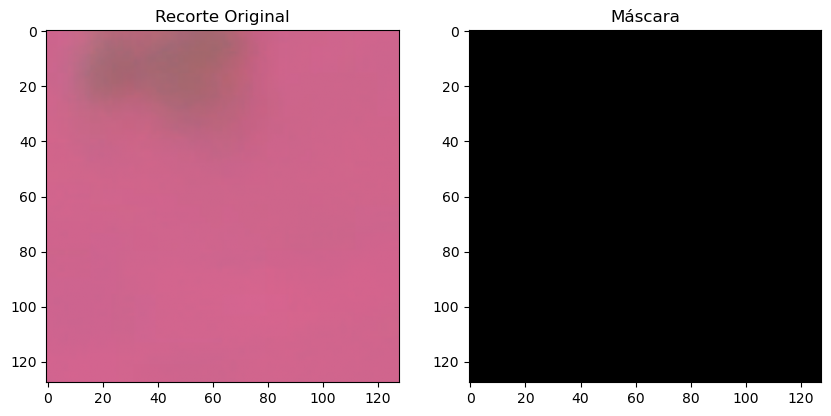

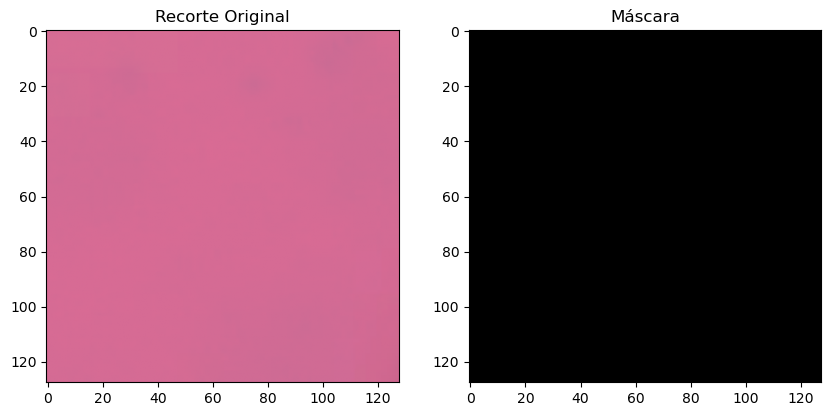

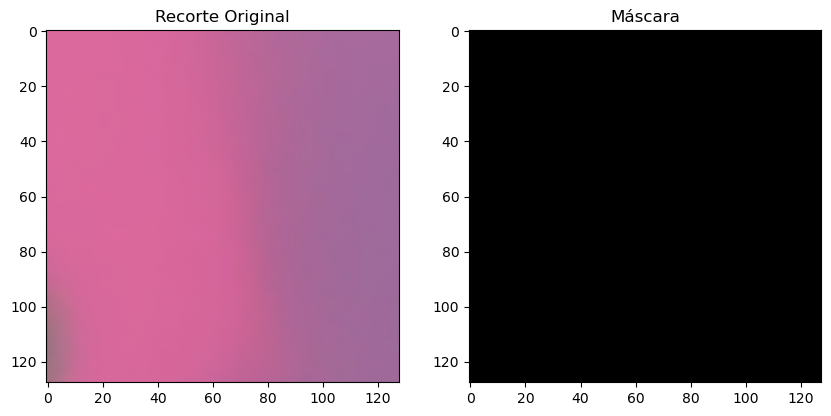

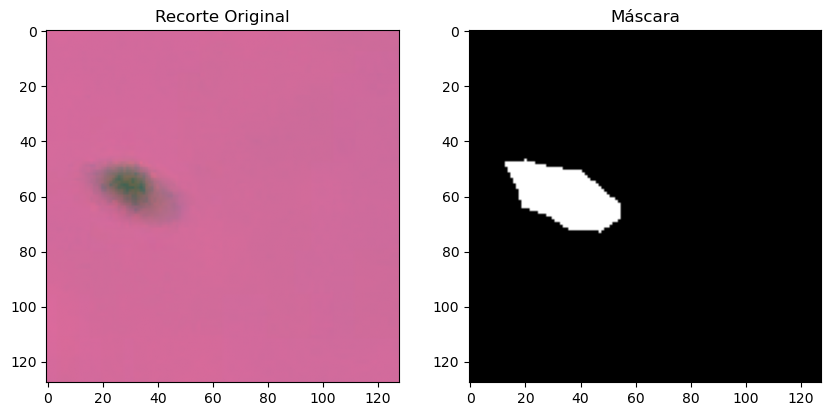

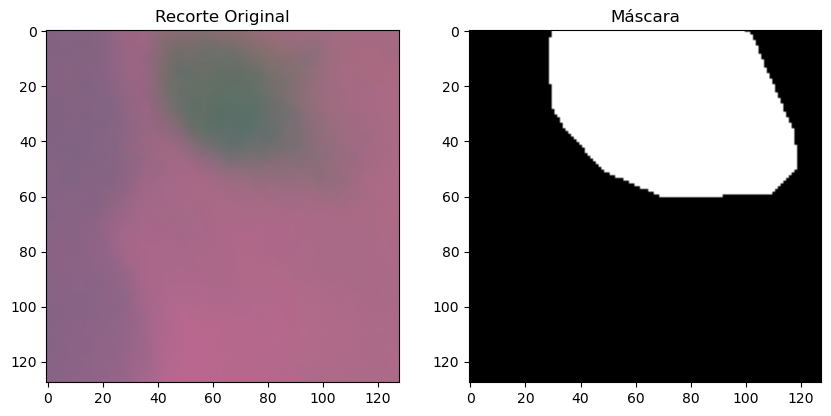

In [34]:
imgs_ = np.random.choice(dataset.index, 5)
for img_ in imgs_:
    exibe2imagens((dataset.loc[img_, 'img']), dataset.loc[img_, 'mask'])

In [35]:
imgs_pre = aplicar_preprocessamento(dataset['img'])

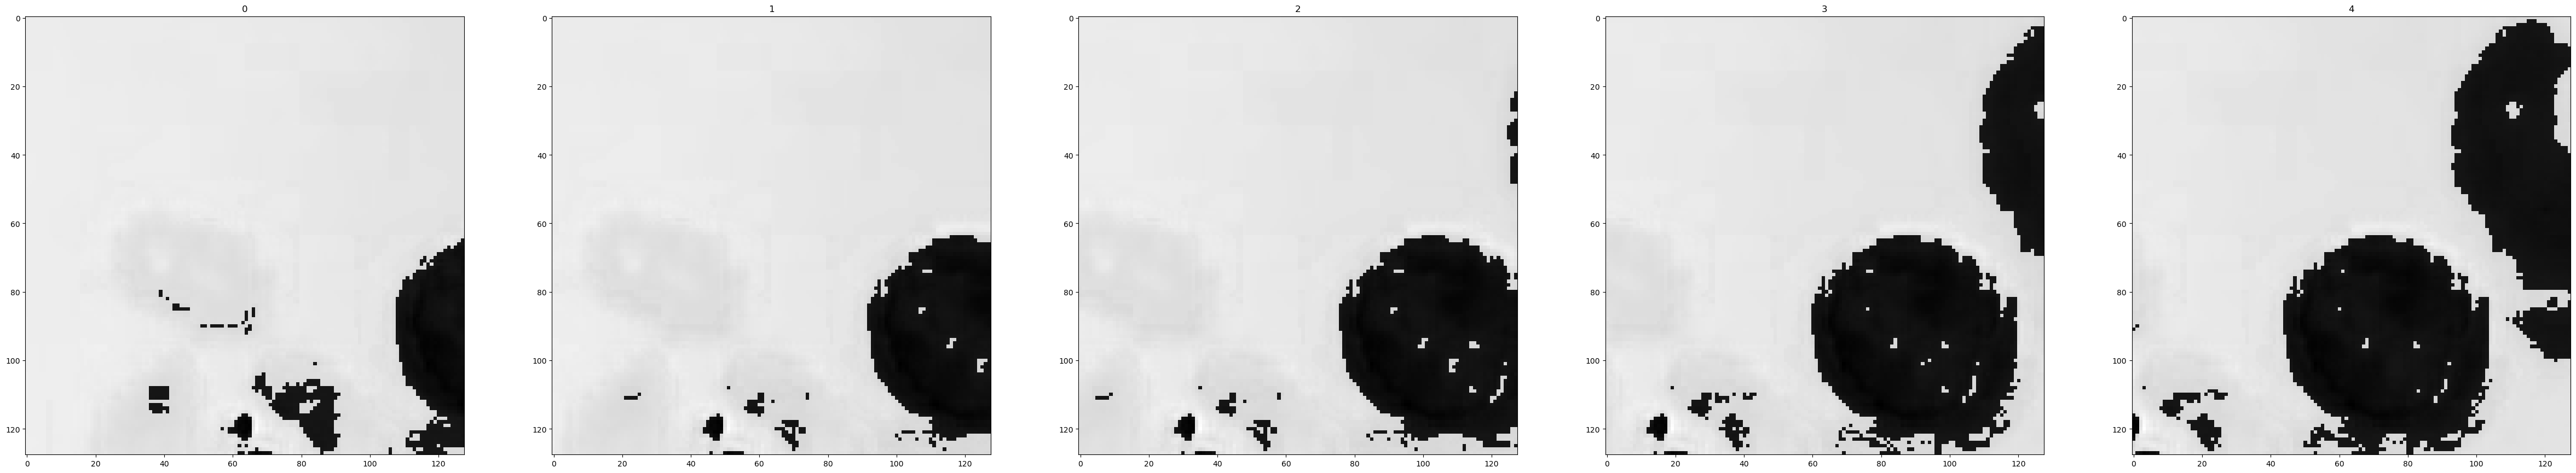

In [36]:
funcaoPlot(imgs_pre[500:505])

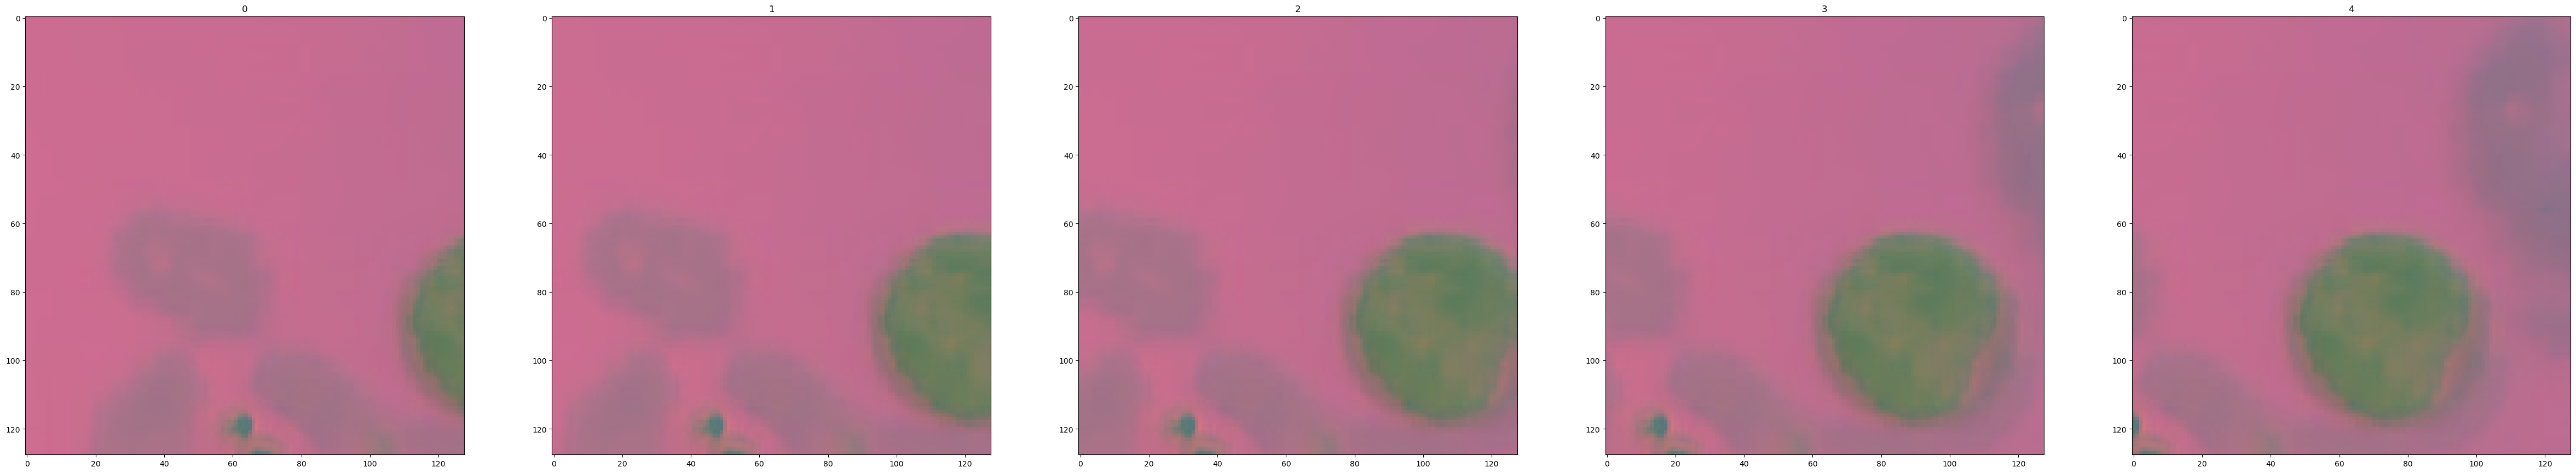

In [37]:
funcaoPlot(dataset['img'][500:505])

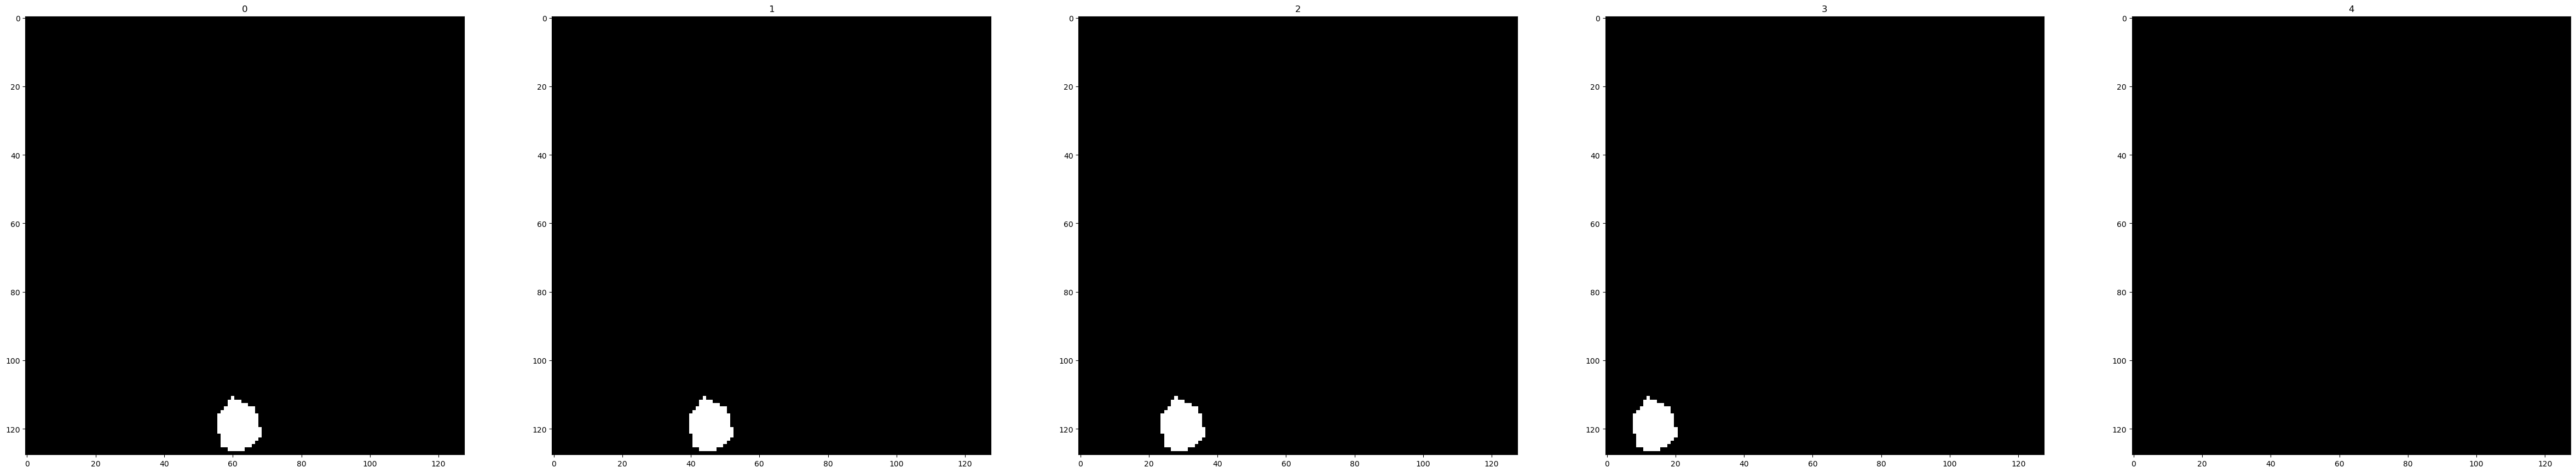

In [38]:
funcaoPlot(dataset['mask'][500:505])

In [106]:
imagens_meanshift = aplicar_menshift(imgs_pre)

Processando Mean Shift: 100%|██████████| 68384/68384 [1:15:55<00:00, 15.01it/s]


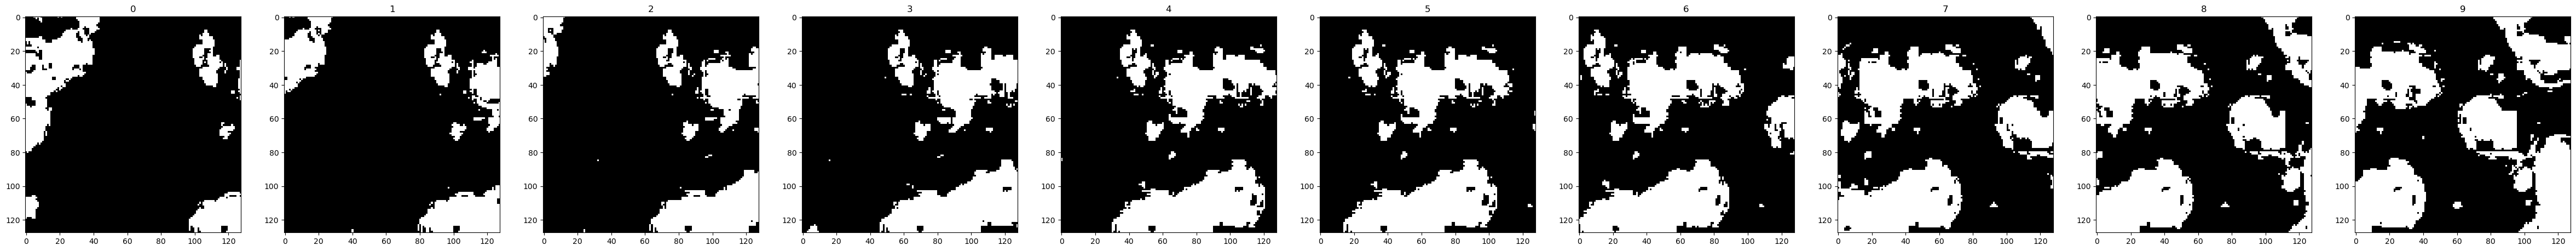

In [107]:
funcaoPlot(imagens_meanshift[20:30])

In [108]:
imagens_meanshift[20:30][0].shape

(128, 128)

In [109]:
dataset['mask'][0].shape

(128, 128, 1)

In [110]:
media_dice(imagens_meanshift, dataset['mask'])

0.2702156071780933

In [111]:
dataset.iloc[1]

img       [[[0.10980392156862745, 0.3686274509803922, 0....
mask      [[[0.0], [0.0], [0.0], [0.0], [0.0], [0.0], [0...
img_id                                                    0
label                                                     0
Name: 1, dtype: object

Processando Mean Shift: 100%|██████████| 34192/34192 [1:33:23<00:00,  6.10it/s]  


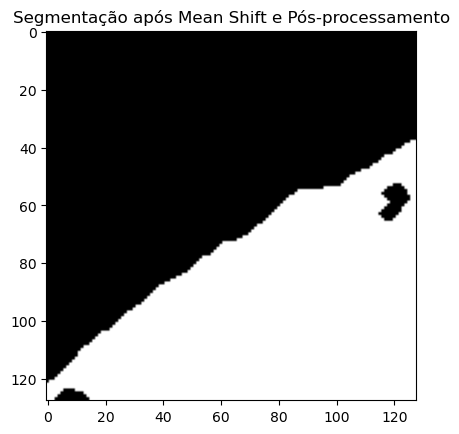

In [50]:
from multiprocessing import Pool
from skimage.color import rgb2gray
from skimage.filters import gaussian, threshold_otsu
from skimage import exposure
from skimage.morphology import opening, closing, disk
from sklearn.cluster import estimate_bandwidth, MeanShift
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

def aplicaMeanShiftOneImg(img):
    img_suavizada = gaussian(img, sigma=1)

    img_gray = rgb2gray(img_suavizada)

    img_eq = exposure.equalize_adapthist(img_gray, clip_limit=0.03)

    # Estimativa do bandwidth para o Mean Shif
    flat_img = img_eq.reshape((-1, 1))
    bandwidth = max(estimate_bandwidth(flat_img, quantile=0.2, n_samples=500), 0.1)

    # Mean Shift
    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)
    ms.fit(flat_img)

    labels = ms.labels_
    segmented = np.reshape(labels, img_eq.shape)

    # Pós-processamento: limpeza usando operações morfológicas
    selem = disk(2) 
    cleaned = closing(opening(segmented, selem), selem)

    return cleaned

def aplicar_menshift_paralelo(list_img):
    with Pool(processes=16) as pool:
        result_list = list(tqdm(pool.imap(aplicaMeanShiftOneImg, list_img), total=len(list_img), desc="Processando Mean Shift"))
    return result_list

# imagens_meanshift2 = aplicar_menshift(dataset['img'])
pool = Pool(processes=16)  
imagens_meanshift2 = aplicar_menshift_paralelo(dataset['img'])
pool.close()
pool.join()

# Exibição dos resultados
plt.figure()
plt.title('Segmentação após Mean Shift e Pós-processamento')
plt.imshow(imagens_meanshift2[0], cmap='gray')
plt.show()


In [51]:
media_dice(imagens_meanshift2, dataset['mask'])


0.400145794766251

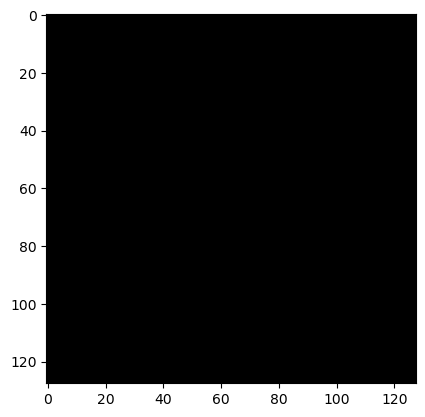

In [53]:
plt.imshow(dataset['mask'][0], cmap='gray')

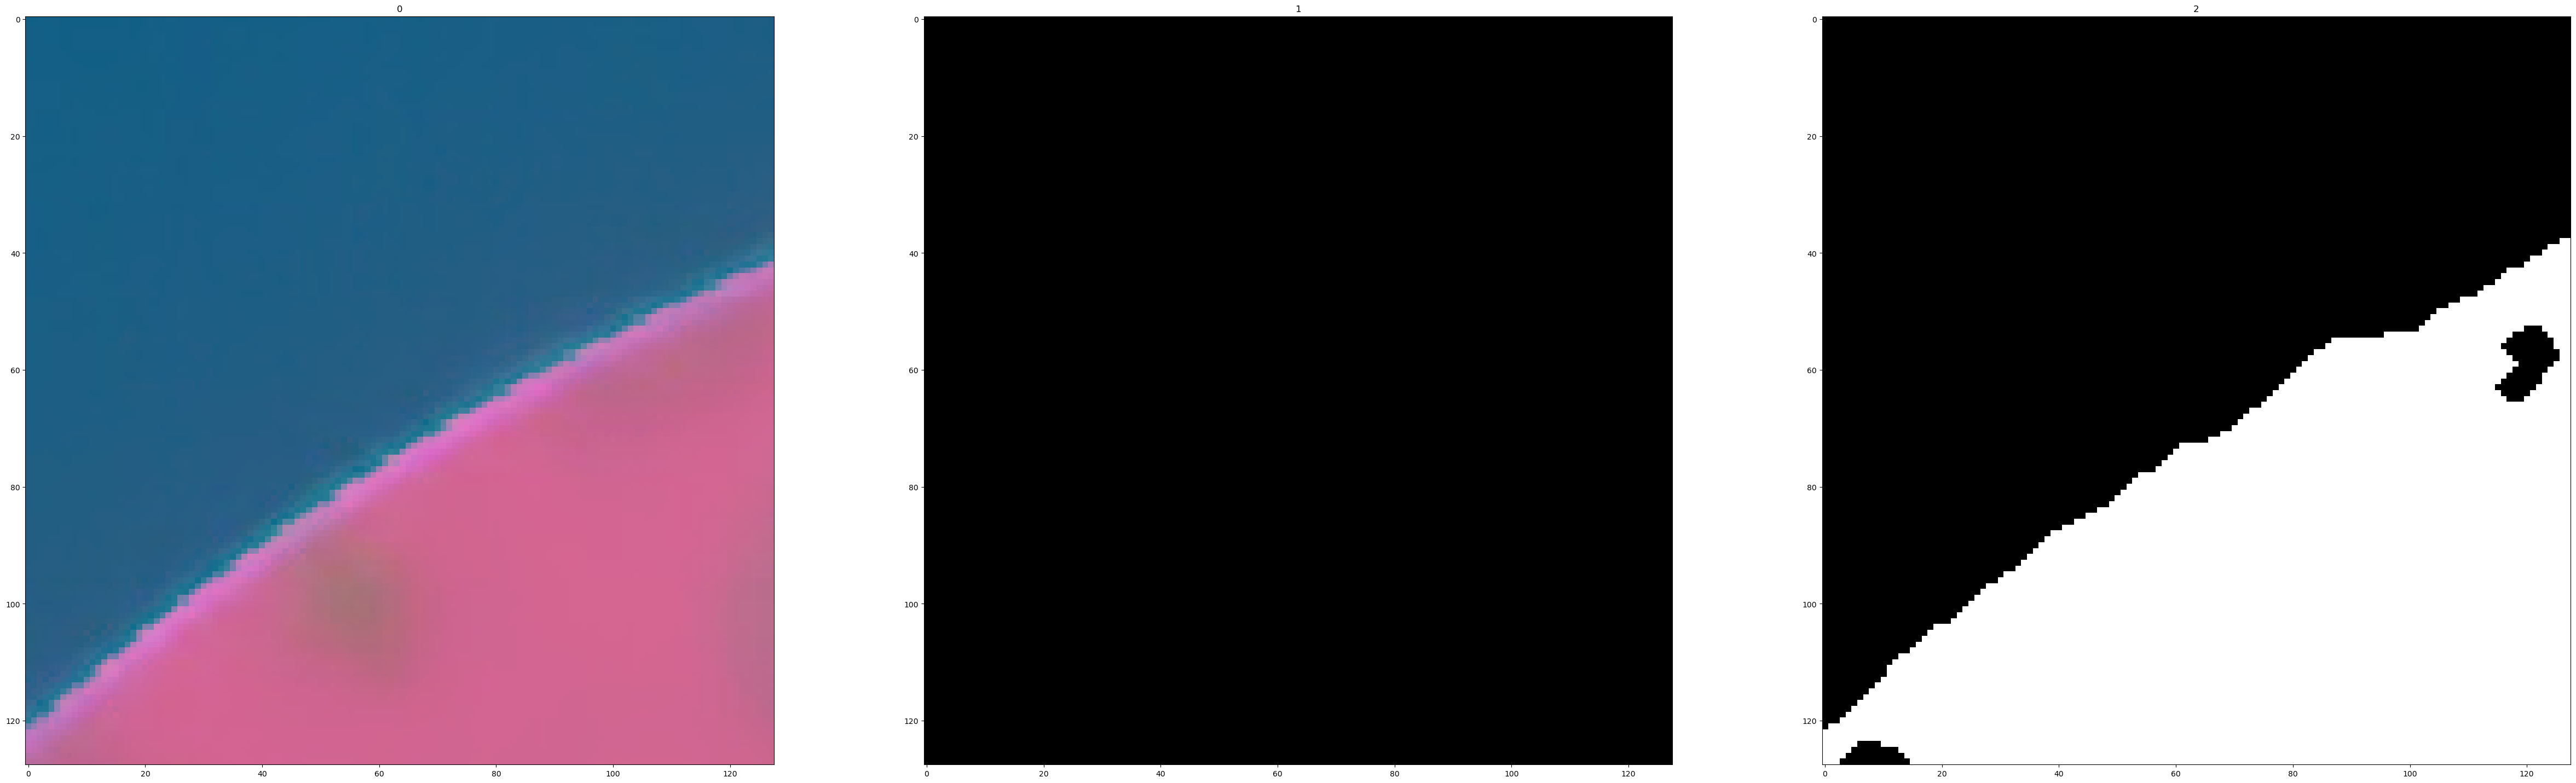

In [55]:
funcaoPlot([dataset['img'][0],dataset['mask'][0],imagens_meanshift2[0]])

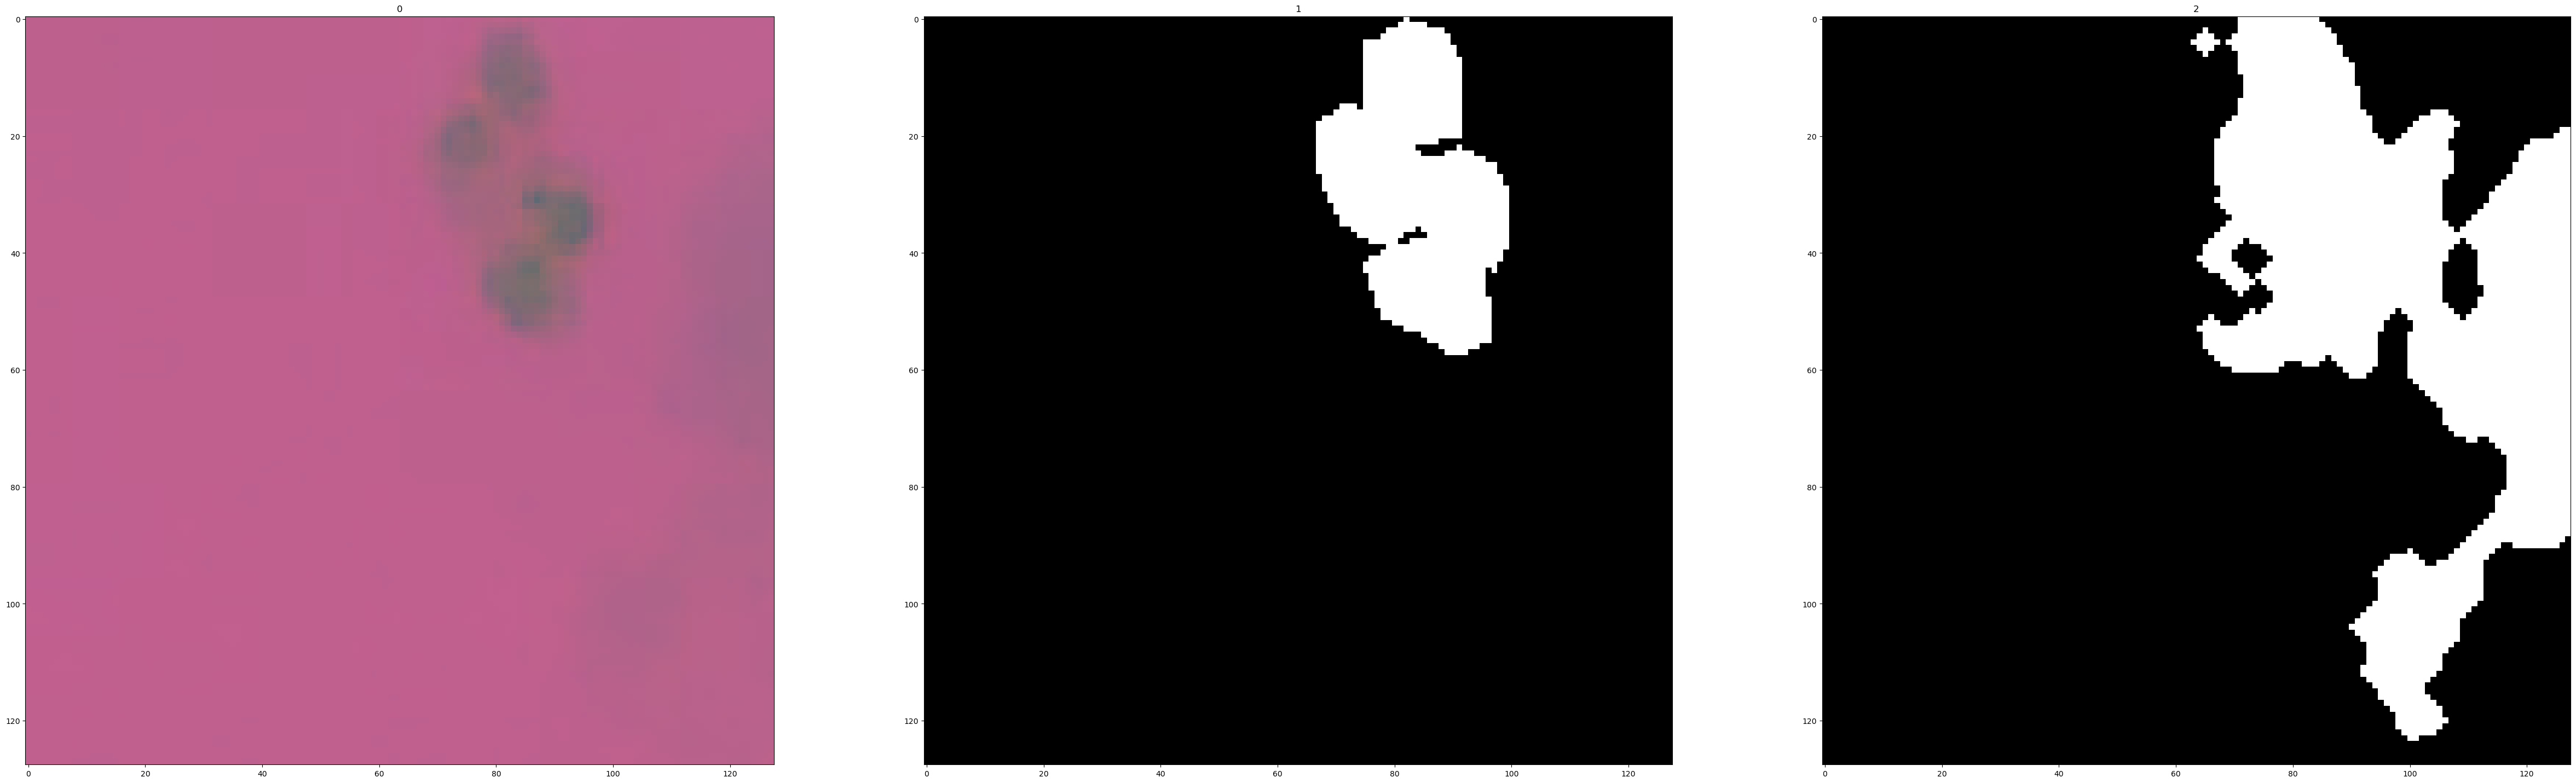

In [56]:
funcaoPlot([dataset['img'][200],dataset['mask'][200],imagens_meanshift2[200]])

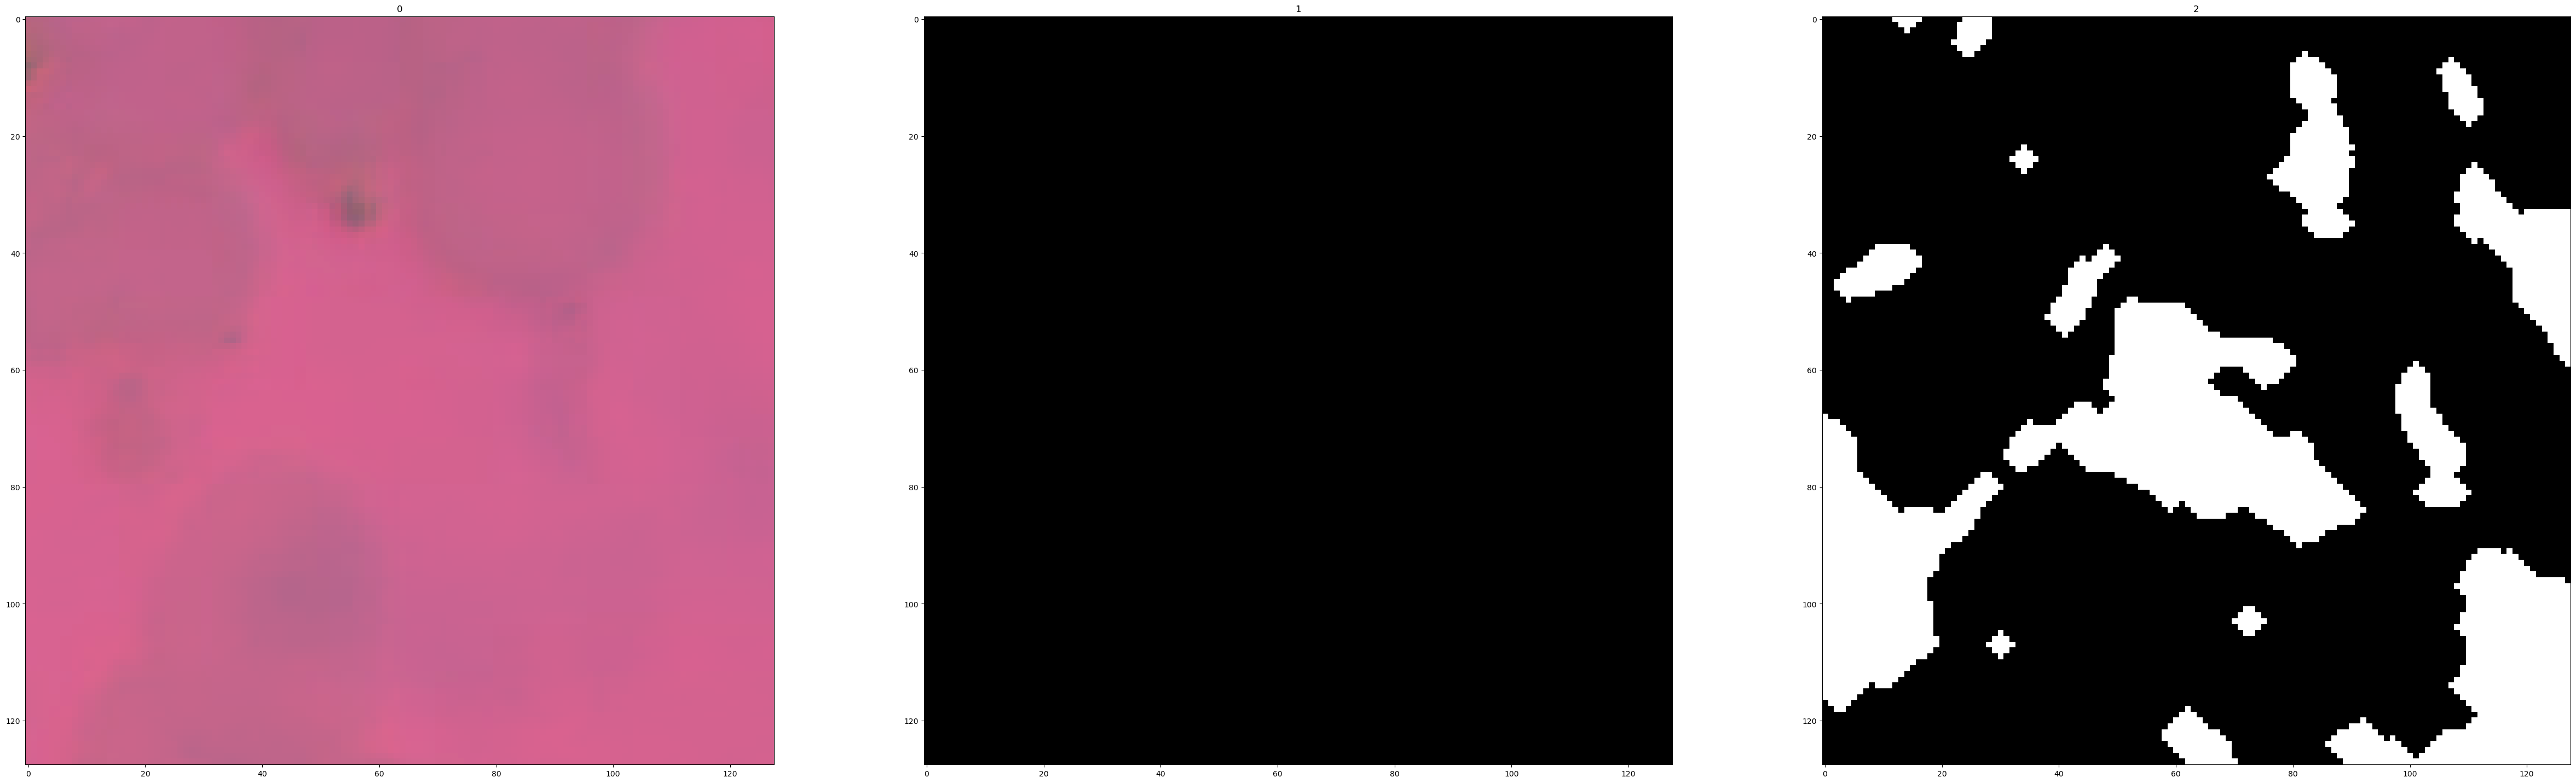

In [57]:
funcaoPlot([dataset['img'][2000],dataset['mask'][2000],imagens_meanshift2[2000]])

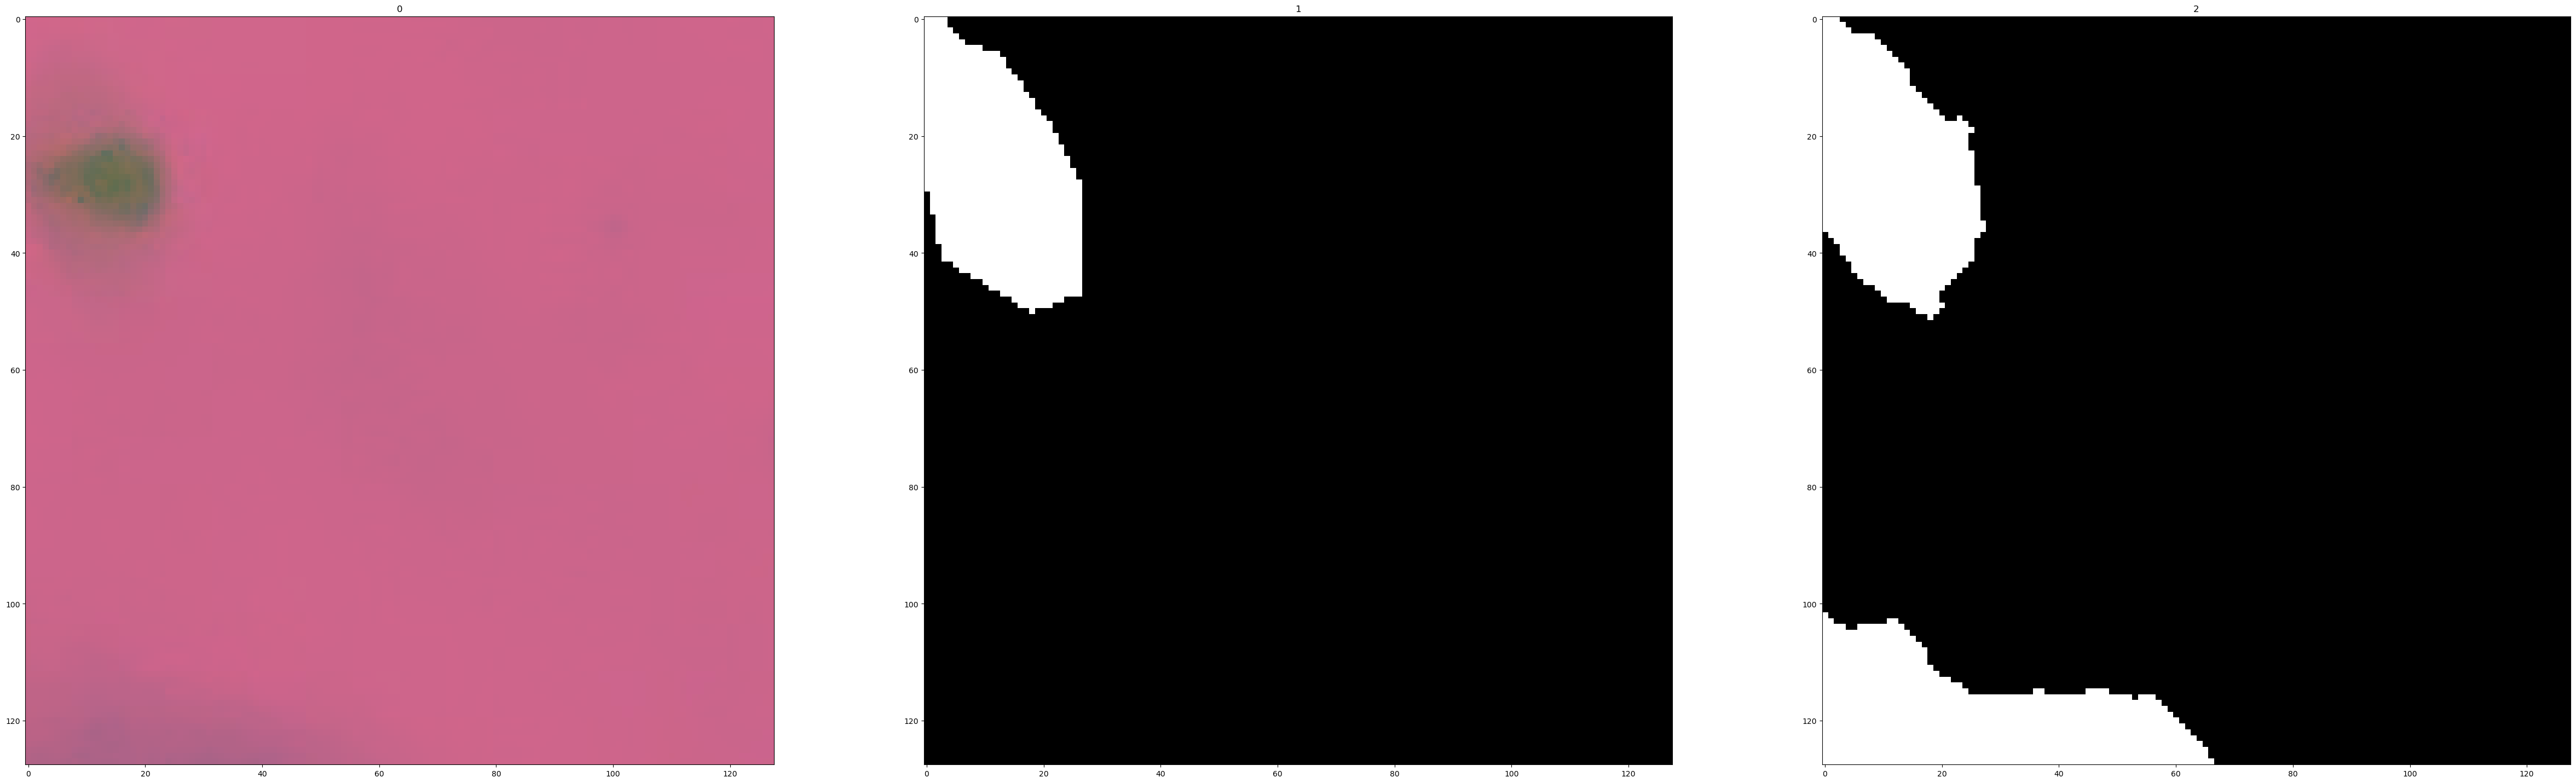

In [58]:
funcaoPlot([dataset['img'][20000],dataset['mask'][20000],imagens_meanshift2[20000]])

Lendo imagens

In [112]:
imagens = imread_collection('PH2Dataset/PH2 Dataset images/*/*' + '_Dermoscopic_Image/*')
mascaras_medico = imread_collection('PH2Dataset/PH2 Dataset images/*/*' + '_lesion/*')

In [ ]:
imagens = imagens
mascaras_medico = mascaras_medico

redimenssionando e trasnsformando em tons de cinza

In [ ]:
imagens_original = [np.array(resize((img), (512, 512))) for img in imagens]
mascaras_medico = [np.array(resize(img, (512, 512))) for img in mascaras_medico]
imagens_gray = [rgb2gray(img) for img in imagens_original]

In [ ]:
from skimage.io import imshow

img = aplicaKmeans(imagens_gray[0].copy())
imshow(img.copy(), cmap='gray')

In [ ]:
img_niblack = aplicaNiblack(imagens_gray[0].copy())
imshow(img_niblack, cmap='gray')

In [ ]:
img_otsu = aplicaOtsu(imagens_gray[0].copy())
imshow(img_otsu, cmap='gray')

In [ ]:
img_meanshift = aplicaMeanShift(imagens_gray[0].copy())
imshow(img_meanshift, cmap='gray')

In [ ]:
#Gaussian Mixture Models (GMM)
img_gmm = aplicaGMM(imagens_gray[0].copy())
imshow(img_gmm, cmap='gray')

In [ ]:
img = imagens_gray[0].copy()

foreground = (img - (img_otsu * img))
background = (img_otsu * img)

plt.figure()
plt.title('Foreground')
plt.imshow(foreground, cmap='gray')
plt.figure()
plt.title('Background')
plt.imshow(background, cmap='gray')

In [ ]:
255 * False

In [ ]:
imshow(img, cmap='gray')

In [ ]:
funcaoPlot(imagens_gray[:5])

In [ ]:
imagens_otsu = limiar_otsu(imagens_gray)

In [ ]:
funcaoPlot(imagens_otsu[:5])

In [ ]:
funcaoPlot(mascaras_medico[:5])

In [ ]:
media_dice(imagens_otsu, mascaras_medico)

In [ ]:
imagens_meanshift = aplicar_menshift(imagens_gray)

In [ ]:
funcaoPlot(imagens_meanshift[:5])

In [ ]:
media_dice(imagens_meanshift, mascaras_medico)

In [ ]:
imagens_gmm = aplicar_gmm(imagens_gray)

In [ ]:
funcaoPlot(imagens_gmm[:5])

In [ ]:
media_dice(imagens_gmm, mascaras_medico)

In [ ]:
imagens_kmeans = aplicar_kmeans(imagens_gray)

In [ ]:
funcaoPlot(imagens_kmeans[:5])

In [ ]:
media_dice(imagens_kmeans, mascaras_medico)

In [ ]:
imagens_niblack = aplicar_niblack(imagens_gray)

In [ ]:
funcaoPlot(imagens_niblack[:5])

In [ ]:
media_dice(imagens_niblack, mascaras_medico)